In [1]:
import sqlite3

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from arch import arch_model
from config import settings
from data import SQLRepository
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

C:\Users\User\anaconda3\lib\site-packages\pydantic\_internal\_fields.py:128: UserWarning: Field "model_directory" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ('settings_',)`.
  warnings.warn(


In [2]:
connection = sqlite3.connect(settings.db_name, check_same_thread=False)
repo = SQLRepository(connection=connection)

print("repo type:", type(repo))
print("repo.connection type:", type(repo.connection))

repo type: <class 'data.SQLRepository'>
repo.connection type: <class 'sqlite3.Connection'>


In [3]:
df_spy = repo.read_table(table_name="SPY", limit=2500)

print("df_spy type:", type(df_spy))
print("df_spy shape:", df_spy.shape)
df_spy.head()

df_spy type: <class 'pandas.core.frame.DataFrame'>
df_spy shape: (2500, 5)


,open,high,low,close,volume
date,,,,,
2024-05-01,501.38,508.19,499.865,500.35,80242839.0
2024-04-30,508.56,509.56,501.980,501.98,77483566.0
2024-04-29,510.09,510.75,507.250,510.06,46415449.0
2024-04-26,506.35,509.88,505.700,508.26,64306118.0
2024-04-25,499.18,504.27,497.490,503.49,69122368.0


In [4]:
def wrangle_data(ticker, n_observations):

    """Extract table data from database. Calculate returns.

    Parameters
    ----------
    ticker : str
        The ticker symbol of the stock (also table name in database).

    n_observations : int
        Number of observations to return.

    Returns
    -------
    pd.Series
        Name will be `"return"`. There will be no `NaN` values.
    """
    # Get table from database
    df = repo.read_table(table_name=ticker, limit=n_observations+1)

    # Sort DataFrame ascending by date
    df.sort_index(ascending=True, inplace=True)

    # Create "return" column
    df["return"] = df["close"].pct_change()*100

    # Return returns
    return df["return"].dropna()

In [5]:
y_spy = wrangle_data(ticker="SPY", n_observations=2500)
y_spy.head()

date
2014-05-28   -0.073099
2014-05-29    0.517295
2014-05-30    0.161148
2014-06-02    0.114179
2014-06-03   -0.051840
Name: return, dtype: float64

In [6]:
y_van = wrangle_data(ticker="VTI", n_observations=2500)

print("y_van type:", type(y_van))
print("y_van shape:", y_van.shape)
y_van.head()

y_van type: <class 'pandas.core.series.Series'>
y_van shape: (2500,)


date
2014-05-28   -0.110954
2014-05-29    0.535191
2014-05-30    0.020088
2014-06-02    0.120506
2014-06-03   -0.040120
Name: return, dtype: float64

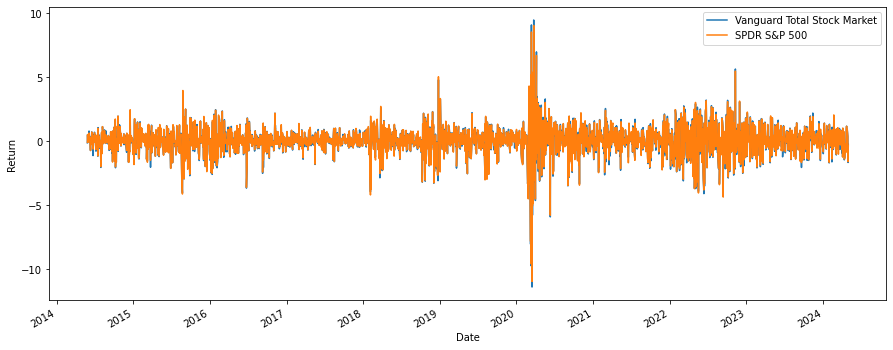

In [7]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for `df_spy` and `df_van`
y_van.plot(ax=ax, label="Vanguard Total Stock Market")
y_spy.plot(ax=ax, label="SPDR S&P 500 ")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

Text(0.5, 1.0, 'Distribution of SPY Cement Daily Returns')

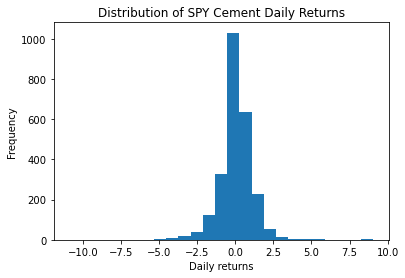

In [8]:
# Create histogram of `y_spy`, 25 bins
plt.hist(y_spy, bins=25)

# Add axis labels
plt.xlabel("Daily returns")
plt.ylabel("Frequency")

# Add title
plt.title("Distribution of SPY Cement Daily Returns")

In [9]:
van_daily_volatility = y_van.std()
spy_daily_volatility = y_spy.std()

print("Van Daily Volatility:",van_daily_volatility)
print("SPY Daily Volatility:", spy_daily_volatility)

Van Daily Volatility: 1.1308694146131073
SPY Daily Volatility: 1.1113340891629968


In [10]:
# Annual Volatilty
van_annual_volatility = van_daily_volatility * np.sqrt(252)
spy_annual_volatility = spy_daily_volatility * np.sqrt(252)

print("Van Annual Volatility:", van_annual_volatility)
print("SPY Annual Volatility:", spy_annual_volatility)

Van Annual Volatility: 17.95199541813285
SPY Annual Volatility: 17.641881740602628


In [11]:
spy_rolling_50d_volatility = y_spy.rolling(window = 50).std().dropna()

print("rolling_50d_volatility type:", type(spy_rolling_50d_volatility))
print("rolling_50d_volatility shape:", spy_rolling_50d_volatility.shape)
spy_rolling_50d_volatility.head()

rolling_50d_volatility type: <class 'pandas.core.series.Series'>
rolling_50d_volatility shape: (2451,)


date
2014-08-06    0.526177
2014-08-07    0.531773
2014-08-08    0.551840
2014-08-11    0.552856
2014-08-12    0.553072
Name: return, dtype: float64

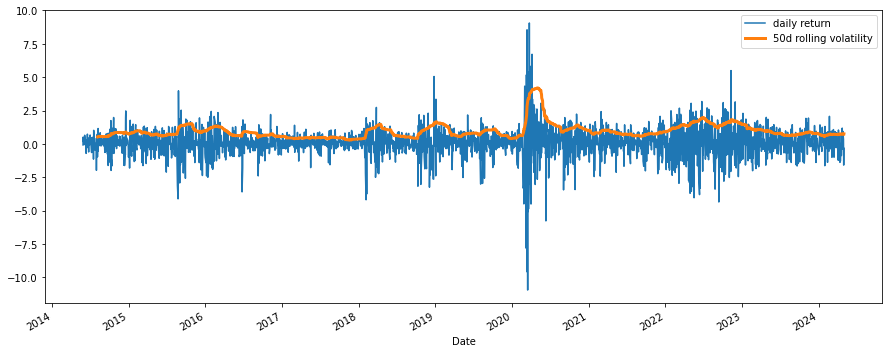

In [12]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_spy`
y_spy.plot(ax=ax, label="daily return")

# Plot `spy_rolling_50d_volatility`
spy_rolling_50d_volatility.plot(ax=ax, label="50d rolling volatility", linewidth=3)

# Add x-axis label
plt.xlabel("Date")

# Add legend
plt.legend();

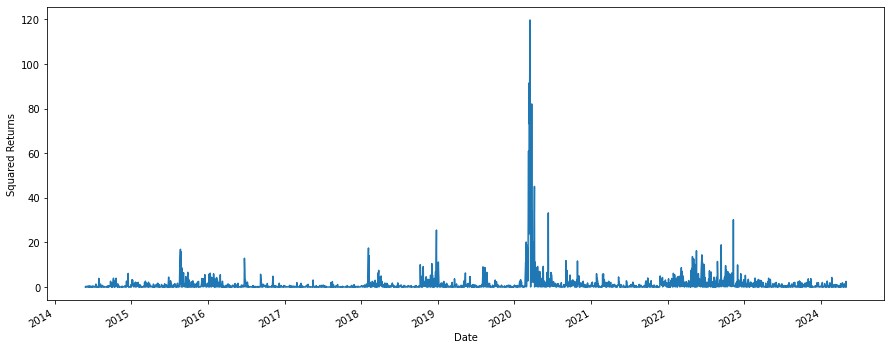

In [13]:
# Squared Returns
fig, ax = plt.subplots(figsize=(15, 6))

# Plot squared returns
(y_spy**2).plot(ax=ax)

# Add axis labels
plt.xlabel("Date")
plt.ylabel("Squared Returns");

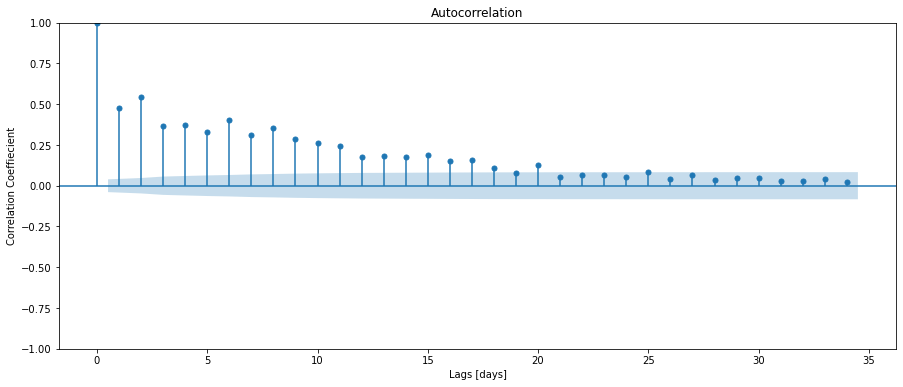

In [14]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared returns
plot_acf(y_spy**2, ax=ax)

# Add axis labels
plt.xlabel("Lags [days]")
plt.ylabel("Correlation Coeffiecient");

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


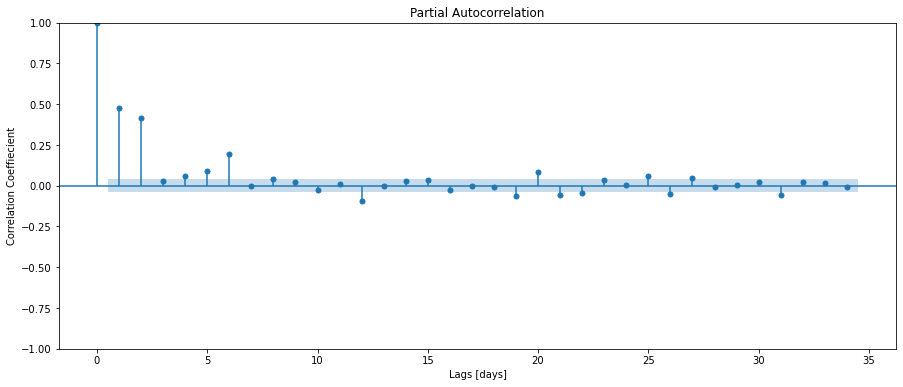

In [15]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create PACF of squared returns
plot_pacf(y_spy**2, ax=ax)

# Add axis labels
plt.xlabel("Lags [days]")
plt.ylabel("Correlation Coeffiecient");


In [16]:
cutoff_test = int(len(y_spy) * 0.8)
y_spy_train = y_spy.iloc[:cutoff_test]

print("y_spy_train type:", type(y_spy_train))
print("y_spy_train shape:", y_spy_train.shape)
y_spy_train.tail()

y_spy_train type: <class 'pandas.core.series.Series'>
y_spy_train shape: (2000,)


date
2022-04-28    2.525942
2022-04-29   -3.695566
2022-05-02    0.601942
2022-05-03    0.458406
2022-05-04    3.045295
Name: return, dtype: float64

In [17]:
# Build and train model
model = arch_model(
    y_spy_train,
    p=1,
    q=1,
    rescale=False
).fit(disp=0)
print("model type:", type(model))

# Show model summary
model.summary()

model type: <class 'arch.univariate.base.ARCHModelResult'>


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                 return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -2446.07
Distribution:                  Normal   AIC:                           4900.13
Method:            Maximum Likelihood   BIC:                           4922.54
                                        No. Observations:                 2000
Date:                Thu, May 02 2024   Df Residuals:                     1999
Time:                        04:09:11   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0845  1.537e-02      5.497  3.859e-08 [5.438e-02,  0.115]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0416  1.019e-02      4.083  4.443e-05 [2.163e-02,6.157e-02]
alpha[1]       0.2255  3.337e-02      6.758  1.394e-11     [  0.160,  0.291]
beta[1]        0.7448  2.896e-02     25.720 7.000e-146     [  0.688,  0.802]
============================================================================

Covariance estimator: robust
"""

In [18]:
model.conditional_volatility.tail()

date
2022-04-28    1.676334
2022-04-29    1.865210
2022-05-02    2.419837
2022-05-03    2.112701
2022-05-04    1.843299
Name: cond_vol, dtype: float64

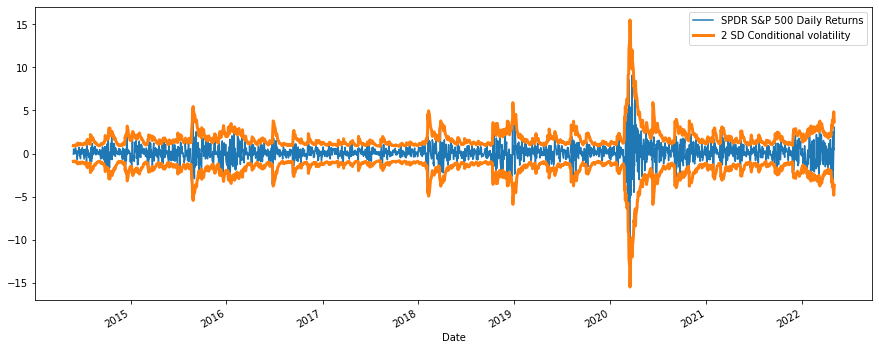

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot `y_spy_train`
y_spy_train.plot(ax=ax, label="SPDR S&P 500 Daily Returns")

# Plot conditional volatility * 2
(2 *model.conditional_volatility).plot(
    ax=ax, color="C1", label="2 SD Conditional volatility", linewidth=3
)

# Plot conditional volatility * -2
(-2 *model.conditional_volatility.rename("")).plot(
    ax=ax, color="C1", linewidth=3
)

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

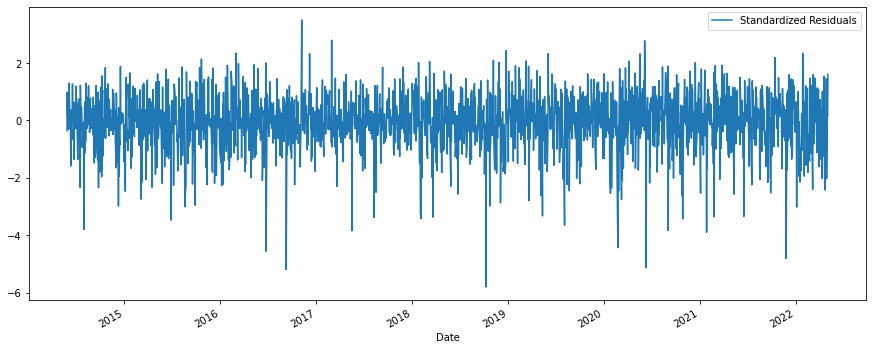

In [20]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot standardized residuals
model.std_resid.plot(ax=ax, label="Standardized Residuals")

# Add axis labels
plt.xlabel("Date")


# Add legend
plt.legend();

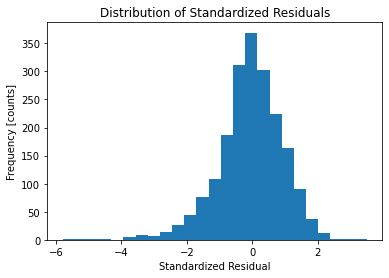

In [21]:
# Create histogram of standardized residuals, 25 bins
plt.hist(model.std_resid, bins=25)

# Add axis labels
plt.xlabel("Standardized Residual")
plt.ylabel("Frequency [counts]")

# Add title
plt.title("Distribution of Standardized Residuals");

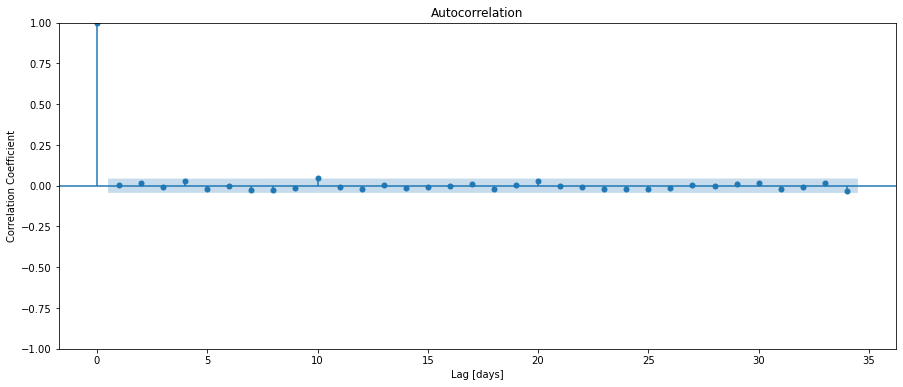

In [22]:
fig, ax = plt.subplots(figsize=(15, 6))

# Create ACF of squared, standardized residuals
plot_acf(model.std_resid**2, ax=ax)

# Add axis labels
plt.xlabel("Lag [days]")
plt.ylabel("Correlation Coefficient");

In [23]:
one_day_forecast = model.forecast(horizon=1, reindex=False).variance

print("one_day_forecast type:", type(one_day_forecast))
one_day_forecast

one_day_forecast type: <class 'pandas.core.frame.DataFrame'>


,h.1
date,
2022-05-04,4.549494


In [24]:
# Create empty list to hold predictions
predictions = []

# Calculate size of test data (20%)
test_size = int(len(y_spy) * 0.2)

# Walk forward
for i in range(test_size):
    # Create test data
    y_train = y_spy.iloc[: -(test_size - i)]

    # Train model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)

    # Generate next prediction (volatility, not variance)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5

    # Append prediction to list
    predictions.append(next_pred)

# Create Series from predictions list
y_test_wfv = pd.Series(predictions, index=y_spy.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()

y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (500,)


date
2022-05-05    2.132954
2022-05-06    2.537509
2022-05-09    2.220792
2022-05-10    2.483010
2022-05-11    2.151947
dtype: float64

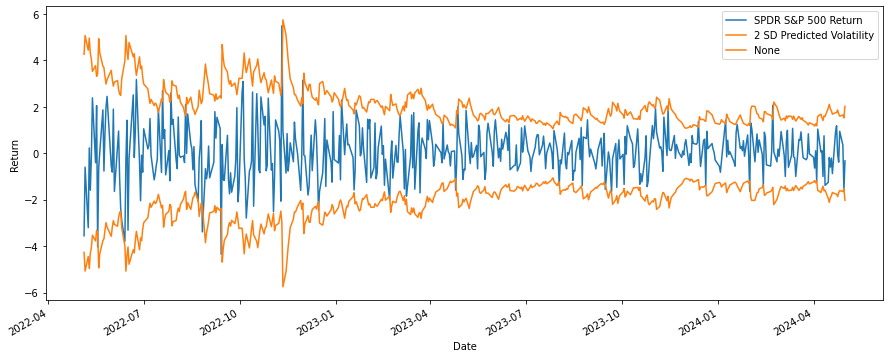

In [25]:
fig, ax = plt.subplots(figsize=(15, 6))

# Plot returns for test data
y_spy.tail(test_size).plot(ax=ax, label="SPDR S&P 500 Return")

# Plot volatility predictions * 2
(2 * y_test_wfv).plot(ax=ax, c="C1", label="2 SD Predicted Volatility")

# Plot volatility predictions * -2
(-2 * y_test_wfv).plot(ax=ax, c="C1")

# Label axes
plt.xlabel("Date")
plt.ylabel("Return")

# Add legend
plt.legend();

In [26]:
# Generate 5-day volatility forecast
prediction = model.forecast(horizon=5, reindex=False).variance ** 0.5
print(prediction)

# Calculate forecast start date
start =  prediction.index[0] + pd.DateOffset(days=1)

# Create date range
prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

# Create prediction index labels, ISO 8601 format
prediction_index = [d.isoformat() for d in prediction_dates]

print("prediction_index type:", type(prediction_index))
print("prediction_index len:", len(prediction_index))
prediction_index[:3]

                 h.1       h.2       h.3       h.4       h.5
date                                                        
2024-04-30  1.010995  1.015588  1.020045  1.024368  1.028562
prediction_index type: <class 'list'>
prediction_index len: 5


['2024-05-01T00:00:00', '2024-05-02T00:00:00', '2024-05-03T00:00:00']

In [27]:
def clean_prediction(prediction):

    """Reformat model prediction to JSON.

    Parameters
    ----------
    prediction : pd.DataFrame
        Variance from a `ARCHModelForecast`

    Returns
    -------
    dict
        Forecast of volatility. Each key is date in ISO 8601 format.
        Each value is predicted volatility.
    """
    # Calculate forecast start date
    start =  prediction.index[0] + pd.DateOffset(days=1)

    # Create date range
    prediction_dates = pd.bdate_range(start=start, periods=prediction.shape[1])

    # Create prediction index labels, ISO 8601 format
    prediction_index = [d.isoformat() for d in prediction_dates]



    # Extract predictions from DataFrame, get square root
    data = prediction.values.flatten() ** 0.5

    # Combine `data` and `prediction_index` into Series
    prediction_formatted = pd.Series(data, index=prediction_index)
    
    # Return Series as dictionary
    return prediction_formatted.to_dict()

In [28]:
prediction = model.forecast(horizon=30, reindex=False).variance
prediction_formatted = clean_prediction(prediction)
prediction_formatted

{'2024-05-01T00:00:00': 1.010994589344253,
 '2024-05-02T00:00:00': 1.0155884890849958,
 '2024-05-03T00:00:00': 1.0200445478737137,
 '2024-05-06T00:00:00': 1.024367559820322,
 '2024-05-07T00:00:00': 1.028562108959287,
 '2024-05-08T00:00:00': 1.0326325814144857,
 '2024-05-09T00:00:00': 1.036583176651434,
 '2024-05-10T00:00:00': 1.0404179179010817,
 '2024-05-13T00:00:00': 1.044140661830238,
 '2024-05-14T00:00:00': 1.047755107525682,
 '2024-05-15T00:00:00': 1.051264804851987,
 '2024-05-16T00:00:00': 1.0546731622368999,
 '2024-05-17T00:00:00': 1.0579834539326518,
 '2024-05-20T00:00:00': 1.0611988267967627,
 '2024-05-21T00:00:00': 1.0643223066316132,
 '2024-05-22T00:00:00': 1.0673568041182764,
 '2024-05-23T00:00:00': 1.0703051203767175,
 '2024-05-24T00:00:00': 1.0731699521814668,
 '2024-05-27T00:00:00': 1.0759538968591862,
 '2024-05-28T00:00:00': 1.078659456892151,
 '2024-05-29T00:00:00': 1.0812890442495138,
 '2024-05-30T00:00:00': 1.0838449844662932,
 '2024-05-31T00:00:00': 1.08632952048829

In [29]:
prediction = model.forecast(horizon=10, reindex=False).variance
prediction_formatted = clean_prediction(prediction)

# Is `prediction_formatted` a dictionary?
assert isinstance(prediction_formatted, dict)

# Are keys correct data type?
assert all(isinstance(k, str) for k in prediction_formatted.keys())

# Are values correct data type
assert all(isinstance(v, float) for v in prediction_formatted.values())

prediction_formatted

{'2024-05-01T00:00:00': 1.010994589344253,
 '2024-05-02T00:00:00': 1.0155884890849958,
 '2024-05-03T00:00:00': 1.0200445478737137,
 '2024-05-06T00:00:00': 1.024367559820322,
 '2024-05-07T00:00:00': 1.028562108959287,
 '2024-05-08T00:00:00': 1.0326325814144857,
 '2024-05-09T00:00:00': 1.036583176651434,
 '2024-05-10T00:00:00': 1.0404179179010817,
 '2024-05-13T00:00:00': 1.044140661830238,
 '2024-05-14T00:00:00': 1.047755107525682}